In [3]:
import sys
sys.path.append('../scripts')

import proplot as pplt
import pandas as pd
from helpers import *
from scipy import stats
import numpy as np
import statsmodels.api as sm
import math

In [4]:
def varClassifier(df, var, newcol, intervals : list[tuple]):
    for i, interval in enumerate(intervals):
        df.loc[np.logical_and(df[var] >= interval[0], df[var] < interval[1]), newcol] = i
    df = df.dropna()
    df = df.astype({newcol: int})
    return df

In [5]:
def sic_cutoff_data(buoy):
    data = era5_data(buoy)    
    sic_cutoff = pd.read_csv("../data/metadata/sic_cutoffs.csv")
    sic_cutoff.index = sic_cutoff["buoy_id"]
    return data[pd.to_datetime(data["datetime"]) < sic_cutoff.loc[buoy].cutoff]

def parseData(buoy):
        df = sic_cutoff_data(buoy)
        df.datetime = df.datetime.astype("datetime64[s]")
        df.index = df.datetime

        dt = pd.Series(df.datetime) - pd.Series(df.datetime).shift()
        dt = dt.dt.total_seconds()

        vx = (df.x_stere - df.x_stere.shift())/dt
        vy = (df.y_stere - df.y_stere.shift())/dt
        v = np.sqrt(vx**2 + vy**2)
        wind_vel = np.sqrt(df['10m_u_wind_mps']**2 + df['10m_v_wind_mps']**2)

        df = df.drop(columns=["10m_u_wind_mps","10m_v_wind_mps"])

        df = df.assign(drift_speed_mps = v, wind_speed_mps=wind_vel).dropna()
        df["drift_ratio"] = df["drift_speed_mps"]/df["wind_speed_mps"]
        df["dep_leg"] = buoy_metadata(buoy)["Deployment Leg"]
        df["buoy_id"] = buoy

        return df

In [6]:
season_ranges = [
    (pd.to_datetime("2019-10-01"), pd.to_datetime("2019-11-30")),
    (pd.to_datetime("2019-11-30"), pd.to_datetime("2020-03-31")),
    (pd.to_datetime("2020-03-31"), pd.to_datetime("2020-05-30")),
    (pd.to_datetime("2020-05-30"), pd.to_datetime("2020-09-01"))
]
wind_ranges = [(0,3), (3,7), (7,100)]
cloud_ranges = [(0,95), (95, 101)]

seasons = ["Freeze-up (Oct-Nov)", "Midwinter (Dec-Mar)", "Melt Onset (Apr-May)", "Summer (Jun-Sep)"]
wind_levels = ["Low Wind", "Medium Wind", "High Wind"]
cloud_covers = ["<95% Clouds", ">95% Clouds"]

meta = buoy_metadata()
valid_buoys = meta[meta["Interp"]==True]

dn1_buoys = valid_buoys[valid_buoys["Deployment Leg"] != 5].index
dn2_buoys = valid_buoys[valid_buoys["Deployment Leg"] == 5].index

buoy_data_list = []

season_data_cutoffs=[1,1,1,1]
for buoy in dn1_buoys[:100]:
    data = parseData(buoy).set_index("datetime")
    for i, r in enumerate(season_ranges):
        valid = len(data[r[0]:r[0]+pd.Timedelta("1d")]) > 0 and len(data[r[1]:r[1]+pd.Timedelta("1d")]) > 0
        if not valid:
            data = data.drop(index=data[r[0]:r[1]].index)
    buoy_data_list.append(data)
df = pd.concat(buoy_data_list)
df = df.reset_index()

df = varClassifier(df, "datetime", "season", season_ranges)
df = varClassifier(df, "total_cloud_cover", "cloud_cover", cloud_ranges)
df = varClassifier(df, "wind_speed_mps", "wind_level", wind_ranges)

buoy_data_list = []

for buoy in dn2_buoys:
    data = parseData(buoy).set_index("datetime")
    for i, r in enumerate(season_ranges):
        valid = len(data[r[0]:r[0]+pd.Timedelta("1d")]) > 0 and len(data[r[1]:r[1]+pd.Timedelta("1d")]) > 0
        if not valid:
            data = data.drop(index=data[r[0]:r[1]].index)
    buoy_data_list.append(data)
df2 = pd.concat(buoy_data_list)
df2 = df2.reset_index()

df2 = varClassifier(df2, "total_cloud_cover", "cloud_cover", cloud_ranges)
df2 = varClassifier(df2, "wind_speed_mps", "wind_level", wind_ranges)
print(df2)

,datetime,longitude,latitude,x_stere,y_stere,data_gap_minutes,sea_level_pressure_hpa,total_cloud_cover,total_column_liquid_water,total_column_ice_water,drift_speed_mps,wind_speed_mps,drift_ratio,dep_leg,buoy_id,cloud_cover,wind_level
0,2020-09-18 14:00:00,106.74119,89.08845,46752.7,86979.0,45.0,1012.2,99.8,0.002,0.021,0.163949,2.574976,0.063670,5,2020M23,1,0
1,2020-09-18 15:00:00,106.83988,89.09372,46333.6,86556.3,60.5,1011.7,98.7,0.003,0.003,0.165347,3.402778,0.048592,5,2020M23,1,1
2,2020-09-18 16:00:00,107.00663,89.09829,45848.7,86253.0,60.0,1011.3,96.4,0.007,0.000,0.158873,3.900820,0.040728,5,2020M23,1,1
3,2020-09-18 17:00:00,107.19410,89.10163,45397.6,86082.7,59.0,1010.6,93.6,0.017,0.000,0.133938,4.307575,0.031094,5,2020M23,0,1
4,2020-09-18 18:00:00,107.37438,89.10337,45039.3,86058.4,89.5,1010.7,98.2,0.028,0.001,0.099756,4.807078,0.020752,5,2020M23,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24309,2020-09-18 00:00:00,107.00678,89.04185,48718.5,91652.3,10.0,1014.8,99.7,0.080,0.003,0.122907,4.181507,0.029393,5,ASFSTUCB3,1,1
24310,2020-09-18 01:00:00,106.91160,89.04630,48643.6,91145.8,10.0,1014.7,100.0,0.079,0.003,0.142224,4.326118,0.032876,5,ASFSTUCB3,1,1
24311,2020-09-18 02:00:00,106.88039,89.05112,48447.3,90659.0,10.0,1014.6,100.0,0.079,0.004,0.145802,3.996999,0.036478,5,ASFSTUCB3,1,1
24312,2020-09-18 03:00:00,106.90732,89.05590,48160.8,90224.8,10.0,1014.4,99.9,0.074,0.005,0.144501,3.086098,0.046823,5,ASFSTUCB3,1,1


In [7]:
def plotJoint(df, var1, var2, categories,
              bins, *, xlims=[], ylims=[], tick_size=5,
              regression=False, ncols=1):

    main_cats = list(categories.keys())
    vars = df[[var1, var2, *main_cats]]
    groups = vars.groupby(main_cats)

    ncols = df[main_cats[-1]].nunique()
    nrows = (len(groups)-1)//ncols + 1
    fig, axs = pplt.subplots(ncols=ncols, nrows=nrows, 
                             figsize=(14,nrows*(12/ncols)), sharex=1, sharey=4,
                             top="6em", left="7em", right="6em", bottom="6em", fontsize=16,
                             xlabel="Wind Speed (m/s)", ylabel="Drift Speed (m/s)")
    #fig.suptitle("2D Histograms of Wind/Drift Speed", fontsize="20")
    colormap = pplt.Colormap(["white"]+["blue"]*2)

    xbounds = xlims
    ybounds = ylims

    for i, group in enumerate(groups):
        title = group[0]
        data = group[1]

        # Clean Outliers
        dsm_iqr = data.drift_speed_mps.quantile(0.75) - data.drift_speed_mps.quantile(0.25)
        dsm_valid = np.logical_and(data.drift_speed_mps < dsm_iqr*1.5 + data.drift_speed_mps.quantile(0.75), 
                                data.drift_speed_mps > data.drift_speed_mps.quantile(0.25) - dsm_iqr*1.5)

        wsm_iqr = data.wind_speed_mps.quantile(0.75) - data.wind_speed_mps.quantile(0.25)
        wsm_valid = np.logical_and(data.wind_speed_mps < wsm_iqr*1.5 + data.wind_speed_mps.quantile(0.75), 
                                data.wind_speed_mps > data.wind_speed_mps.quantile(0.25) - wsm_iqr*1.5)

        data = data.where(np.logical_and(dsm_valid, wsm_valid)).dropna()

        if len(xlims) != 2:
            xbounds = [data[var1].min(), data[var1].max()]
        if len(ylims) != 2:
            ybounds = [data[var2].min(), data[var2].max()]

        x_bins = np.linspace(*xbounds, bins[0])
        y_bins = np.linspace(*ybounds, bins[1])

        x_center, y_center = 0.5*(x_bins[1:] + x_bins[:-1]), 0.5*(y_bins[1:] + y_bins[:-1])
        
        binned = np.histogram2d(data[var1], data[var2], bins=[x_bins, y_bins])[0]
        binned = pd.DataFrame(binned, index=x_center, columns=y_center)

        c = axs[i].contour(binned.T, cmap=colormap, discrete=True)

        ax_identifier = " at ".join([categories[key][int(idx)] for key, idx in zip(main_cats, title)])
        axs[i].format(title=ax_identifier,
                    xlocator=np.arange(xbounds[0],xbounds[1],tick_size), 
                    xminorlocator=np.arange(xbounds[0],xbounds[1],tick_size/2))

        # Do the regression
        mod = sm.OLS(data[var2],data[var1])
        res = mod.fit()
        overlay = x_center * res.params.iloc[0]
        axs[i].plot(x_center, overlay, color="red")
        axs[i].text(8.5, 0.35, f"y={round(res.params.iloc[0],4)}x", size=18)
    return fig, axs

Text(0.5, 0.98, 'DN2')

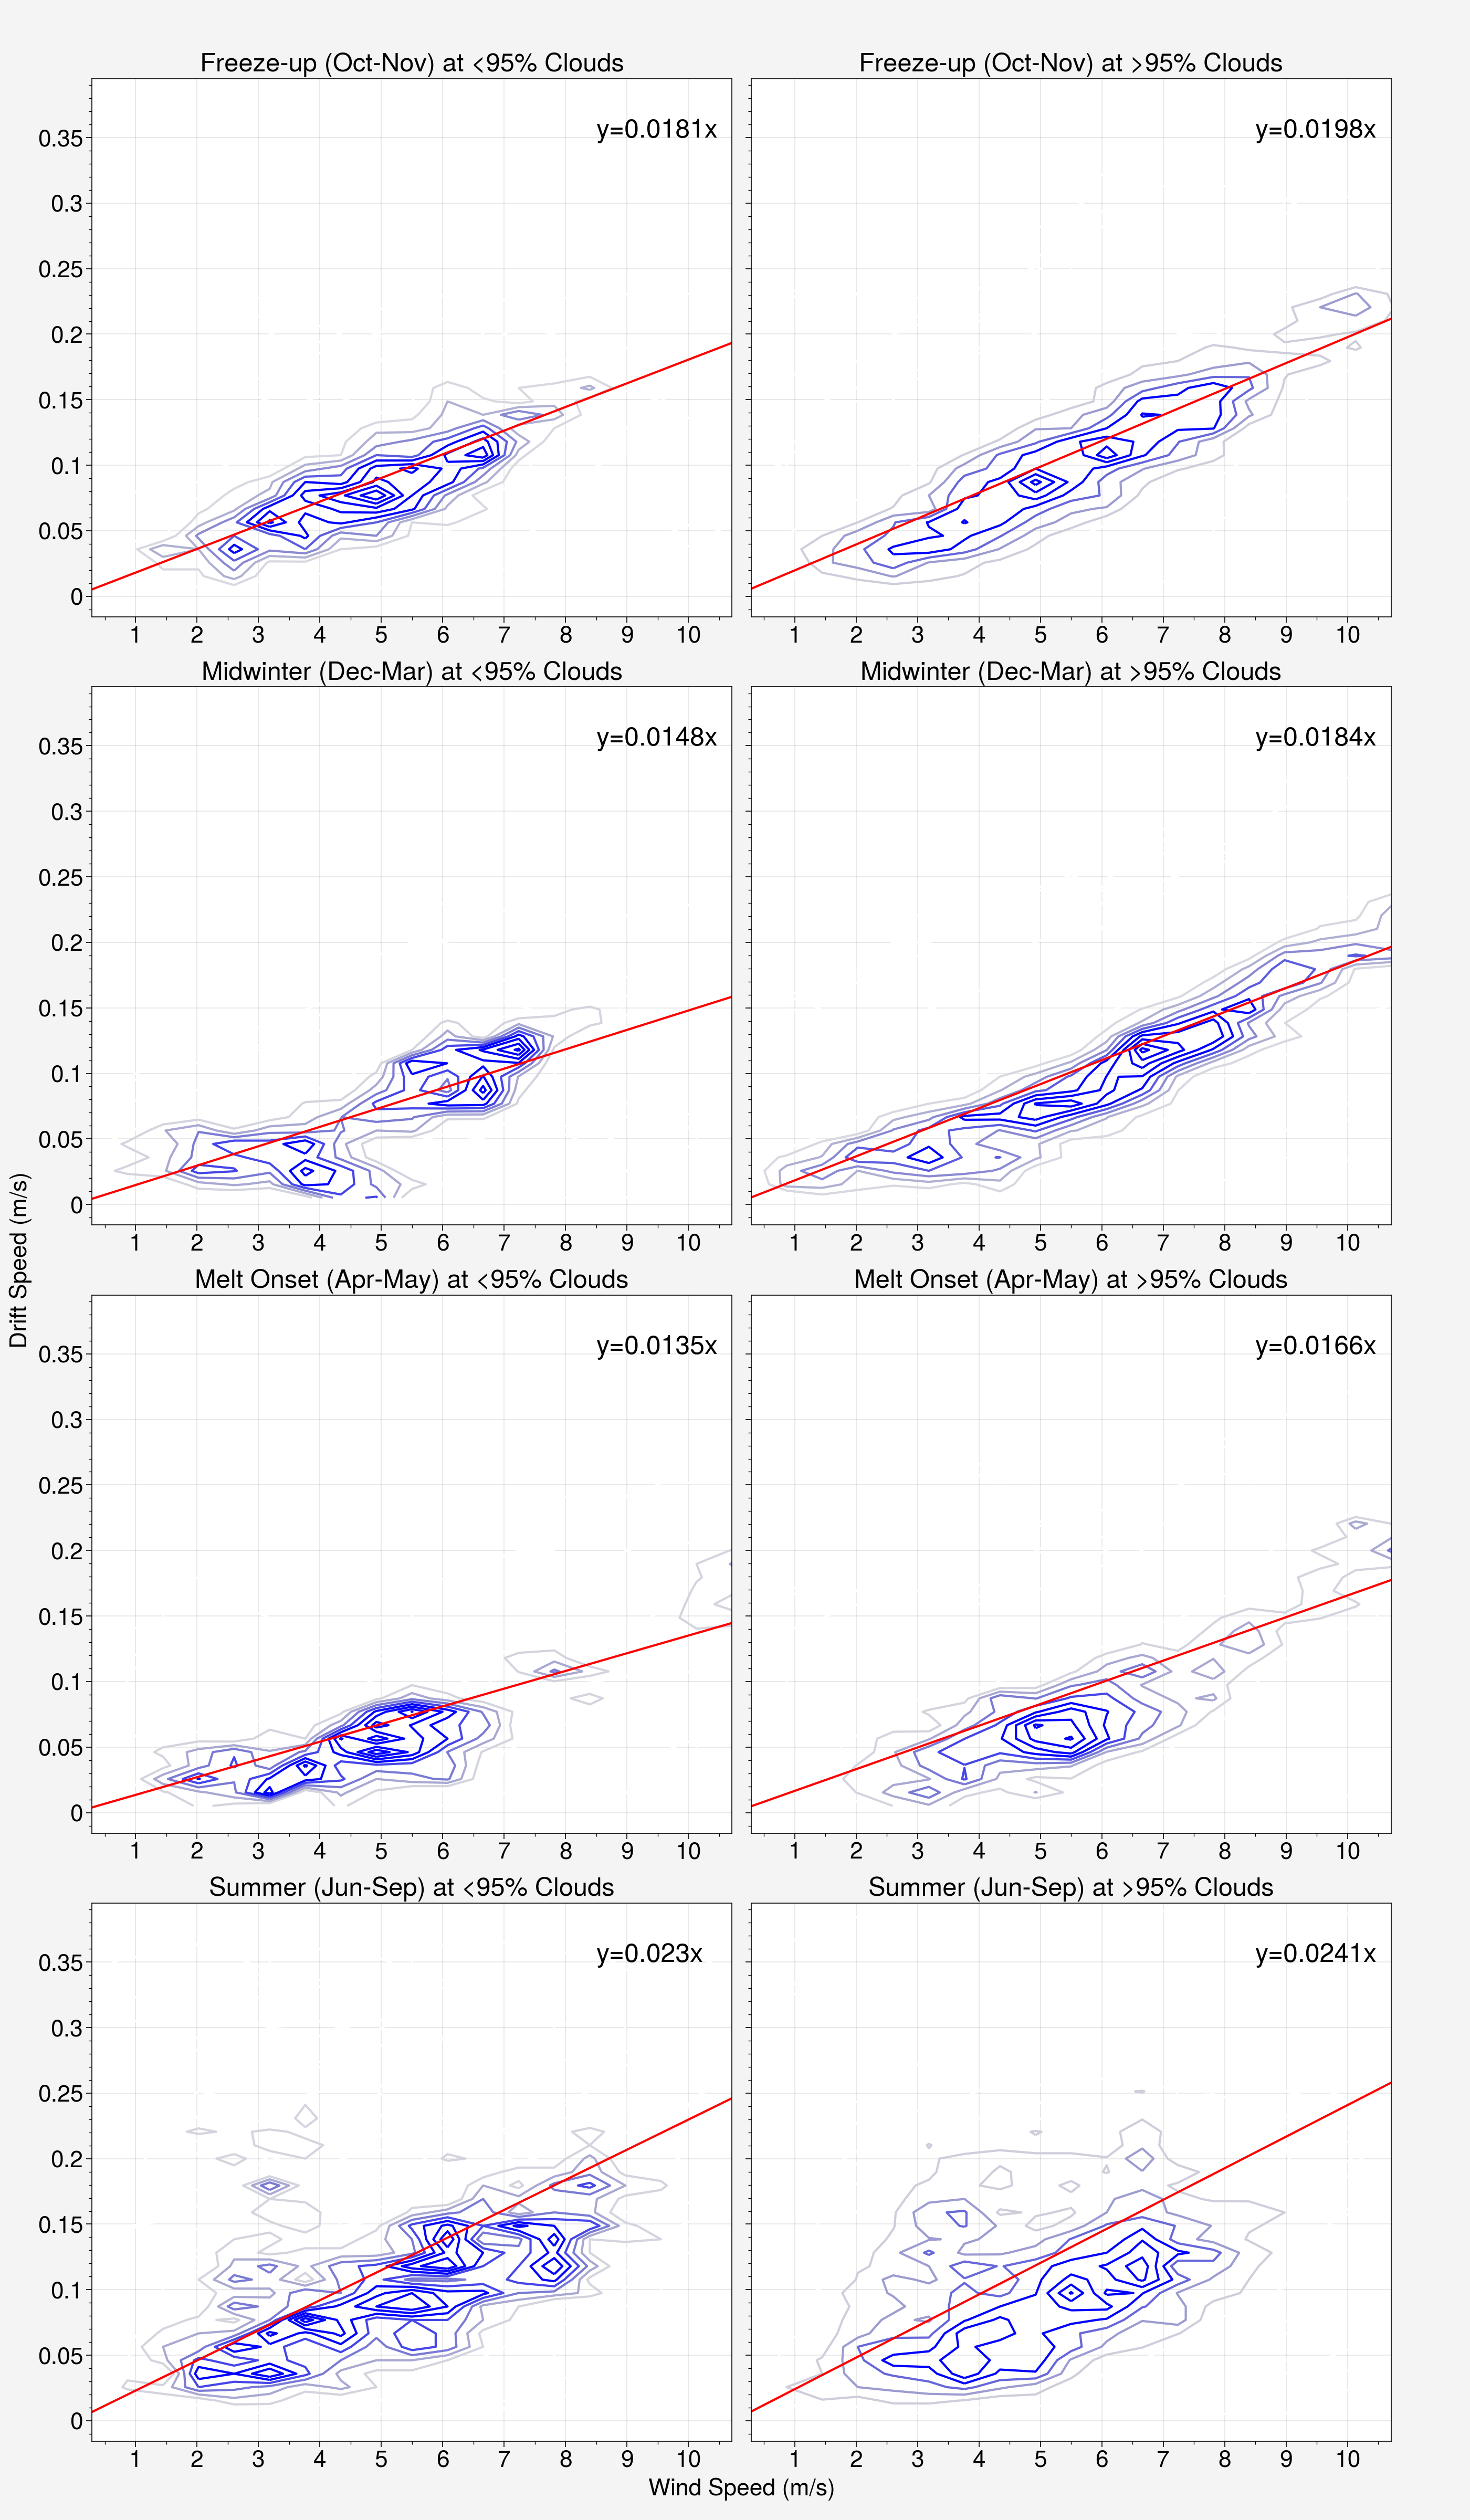

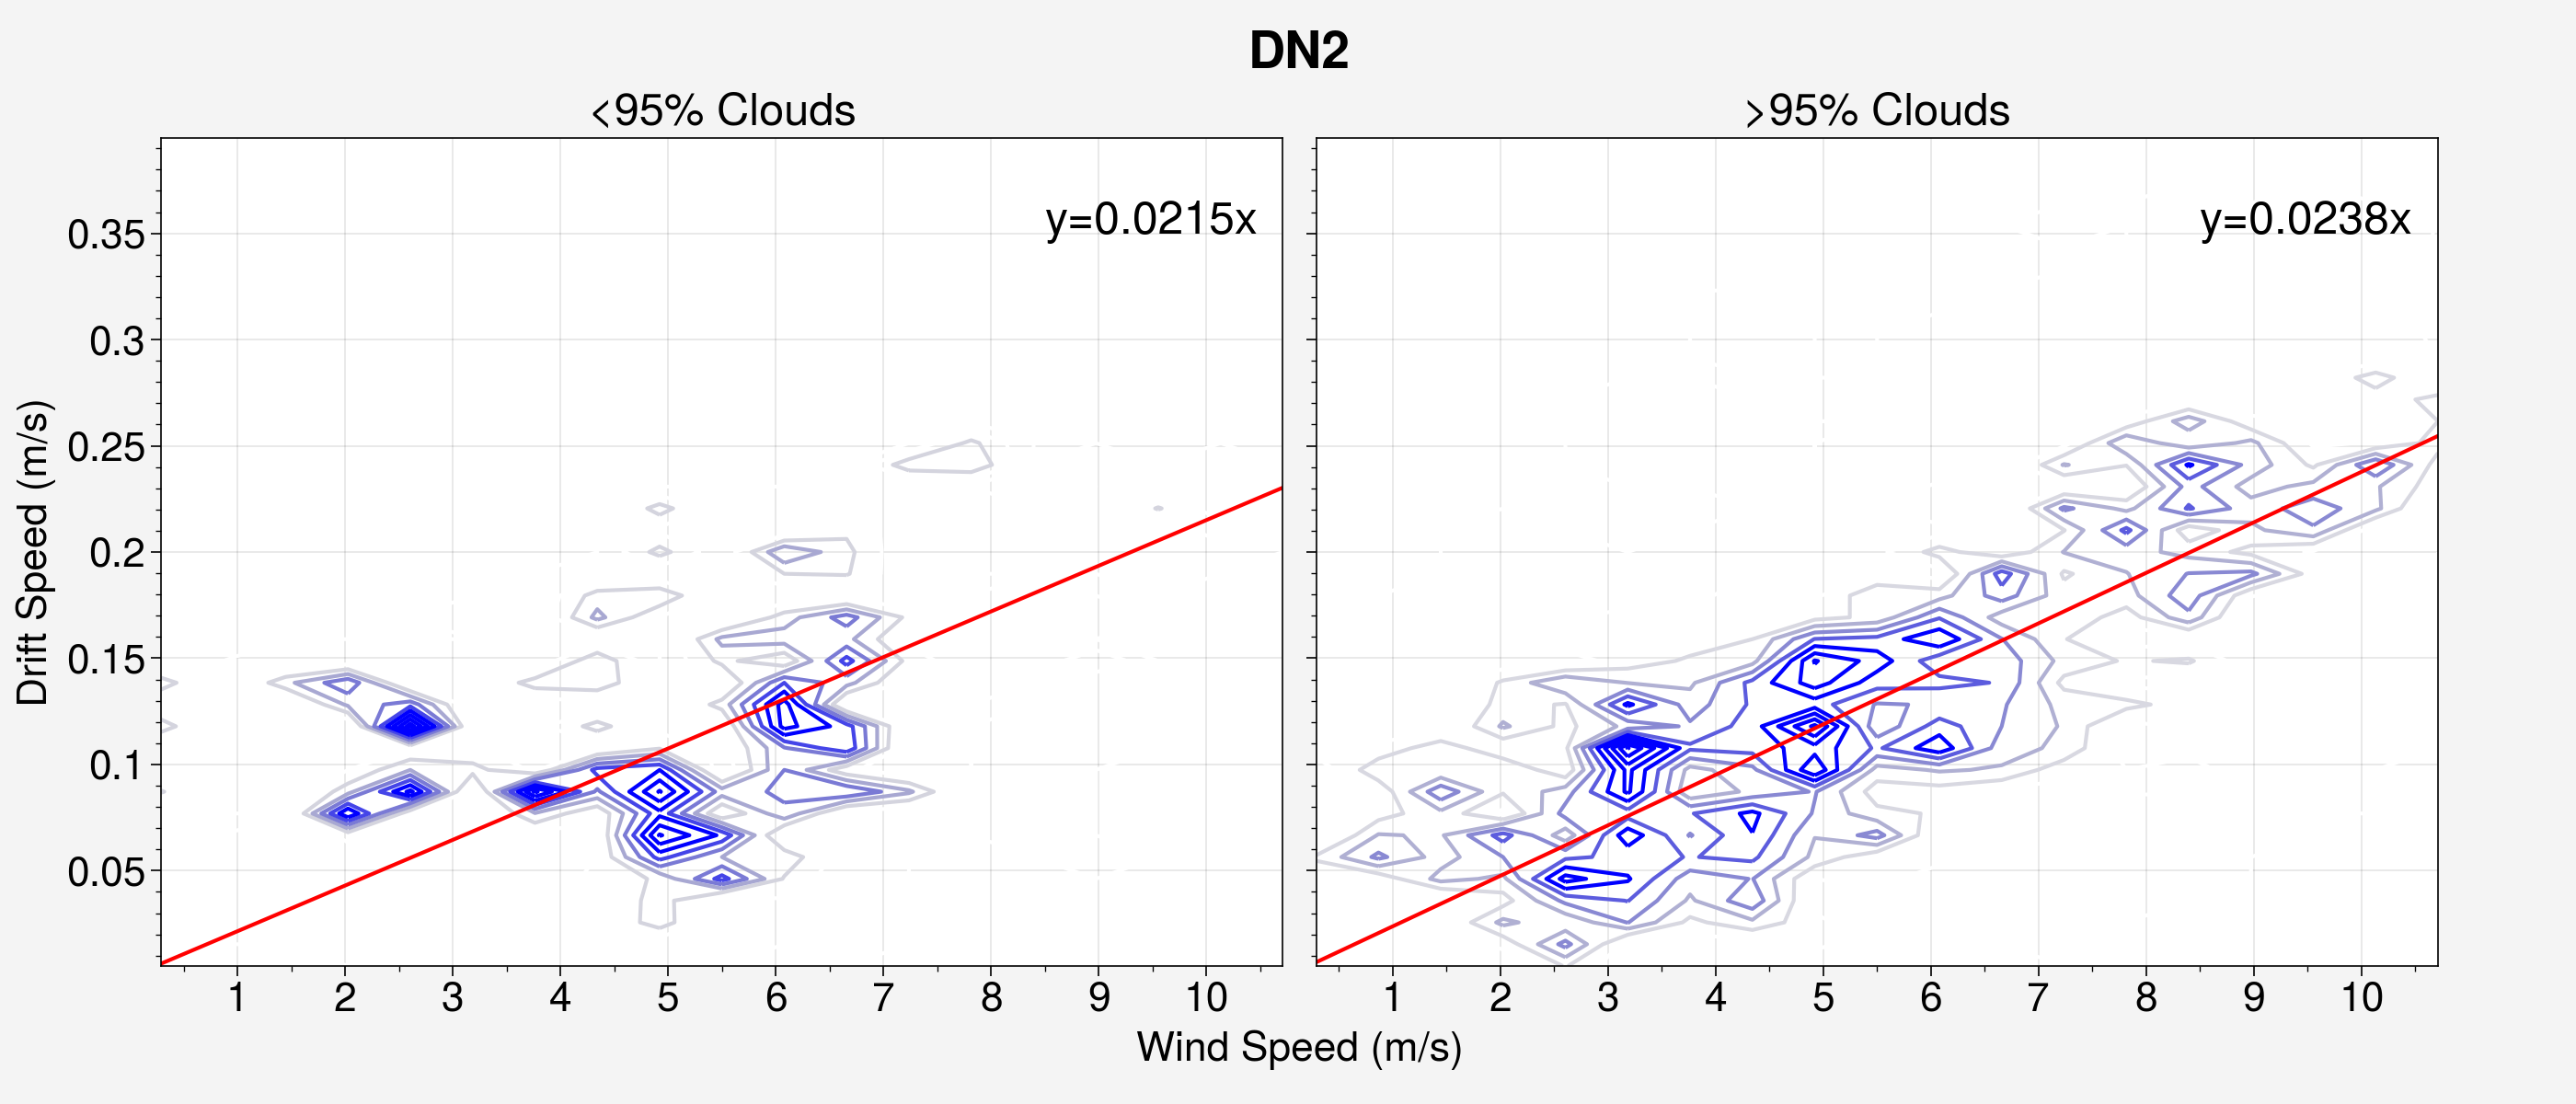

In [8]:
fig, axs = plotJoint(df, "wind_speed_mps", "drift_speed_mps", 
        categories = {"season": seasons, "cloud_cover": cloud_covers}, 
        bins=[20,40], ylims=[0,0.4], xlims=[0,11], tick_size=1)

fig, axs = plotJoint(df2, "wind_speed_mps", "drift_speed_mps", 
        categories = {"cloud_cover": cloud_covers}, 
        bins=[20,40], ylims=[0,0.4], xlims=[0,11], tick_size=1)
fig.suptitle("DN2", fontsize=20)

In [9]:
def summaryStats(df, columns, categories):
    summaries=[]
    vars = df[[*columns, *categories]]
    groups = vars.groupby(categories[::-1])
    
    for i, group in enumerate(groups):
        data = group[1]
        summary = {}

        for var in categories:
            summary[var] = data.iloc[0][var]
        
        for var in columns:
            summary[f"{var} 0.25q"] = data[var].quantile(0.25)
            summary[f"{var} median"] = data[var].quantile(0.5)
            summary[f"{var} 0.75q"] = data[var].quantile(0.75)
    
        summary["num_obs"] = len(data)
        summaries.append(pd.DataFrame(summary, index=[str(group[0])]))
    return pd.concat(summaries, axis=0).reset_index(drop=True)

In [10]:
print(summaryStats(df, ["drift_ratio"], ["cloud_cover", "season", "wind_level"]))

,cloud_cover,season,wind_level,drift_ratio 0.25q,drift_ratio median,drift_ratio 0.75q,num_obs
0,0.0,0.0,0.0,0.011691,0.018830,0.025749,317
1,1.0,0.0,0.0,0.011783,0.019251,0.029762,1133
2,0.0,1.0,0.0,0.012506,0.018044,0.027523,5789
3,1.0,1.0,0.0,0.012612,0.018453,0.023891,15992
4,0.0,2.0,0.0,0.010215,0.015974,0.025580,2122
5,1.0,2.0,0.0,0.009130,0.016050,0.024561,4221
6,0.0,3.0,0.0,0.021908,0.045733,0.100747,578
7,1.0,3.0,0.0,0.023764,0.046782,0.089341,2674
8,0.0,0.0,1.0,0.014021,0.017161,0.020930,1298
9,1.0,0.0,1.0,0.013908,0.018094,0.022346,4682


In [11]:
colors = ["black", "red", "blue"]
def nextColor():
    i = 0
    while True:
        yield colors[i%len(colors)]
        i+=1
def makeHist(df, var, *, categories, overlays, num_bins, tick_size=0.01, lims=[]):
    if len(lims) != 2:
        lims = [0, df[var].max()]
    bins = np.linspace(*lims, num_bins)

    main_cats = list(categories.keys())[::-1]
    overlay_cats = list(overlays.keys())

    vars = df[[var, *main_cats, *overlay_cats]]
    groups = vars.groupby(main_cats)
    
    fig, ax = pplt.subplots(figsize=(10,len(groups)*3), nrows=len(groups), sharex=False)
    for i, group in enumerate(groups):
        group_name, group_data = group

        overlay_groups = group_data.groupby(overlay_cats)
        color_dict = {}
        color_gen = nextColor()
        for overlay_group_name, data in overlay_groups:
            if overlay_group_name[0] == 0:
                ls = "-"
            else:
                ls = "--"
            if overlay_group_name[1:] not in color_dict:
                color_dict[overlay_group_name[1:]] = next(color_gen)
            color = color_dict[overlay_group_name[1:]]

            overlay_identifier = " ".join([overlays[key][idx] for key, idx in zip(overlay_cats, overlay_group_name)])
            ax[i].hist(data[var], 
                       bins=bins, 
                       label=overlay_identifier,
                       histtype="step", lw=2, ls=ls, 
                       #alpha=0.3,
                       color=color,
                       weights=np.ones(len(data[var])) / len(data[var]))
        ax_identifier = " ".join([categories[key][idx] for key, idx in zip(main_cats, group_name)])
        ax[i].format(title=ax_identifier, 
                     xlocator=np.arange(lims[0],lims[1],tick_size), 
                     xminorlocator=np.arange(lims[0],lims[1],tick_size/2),
                     xlabel="Drift Ratio", ylabel="Relative Frequency")
    ax[0].legend(loc="lower center", bbox_to_anchor=(0,1.15,1,0.2))

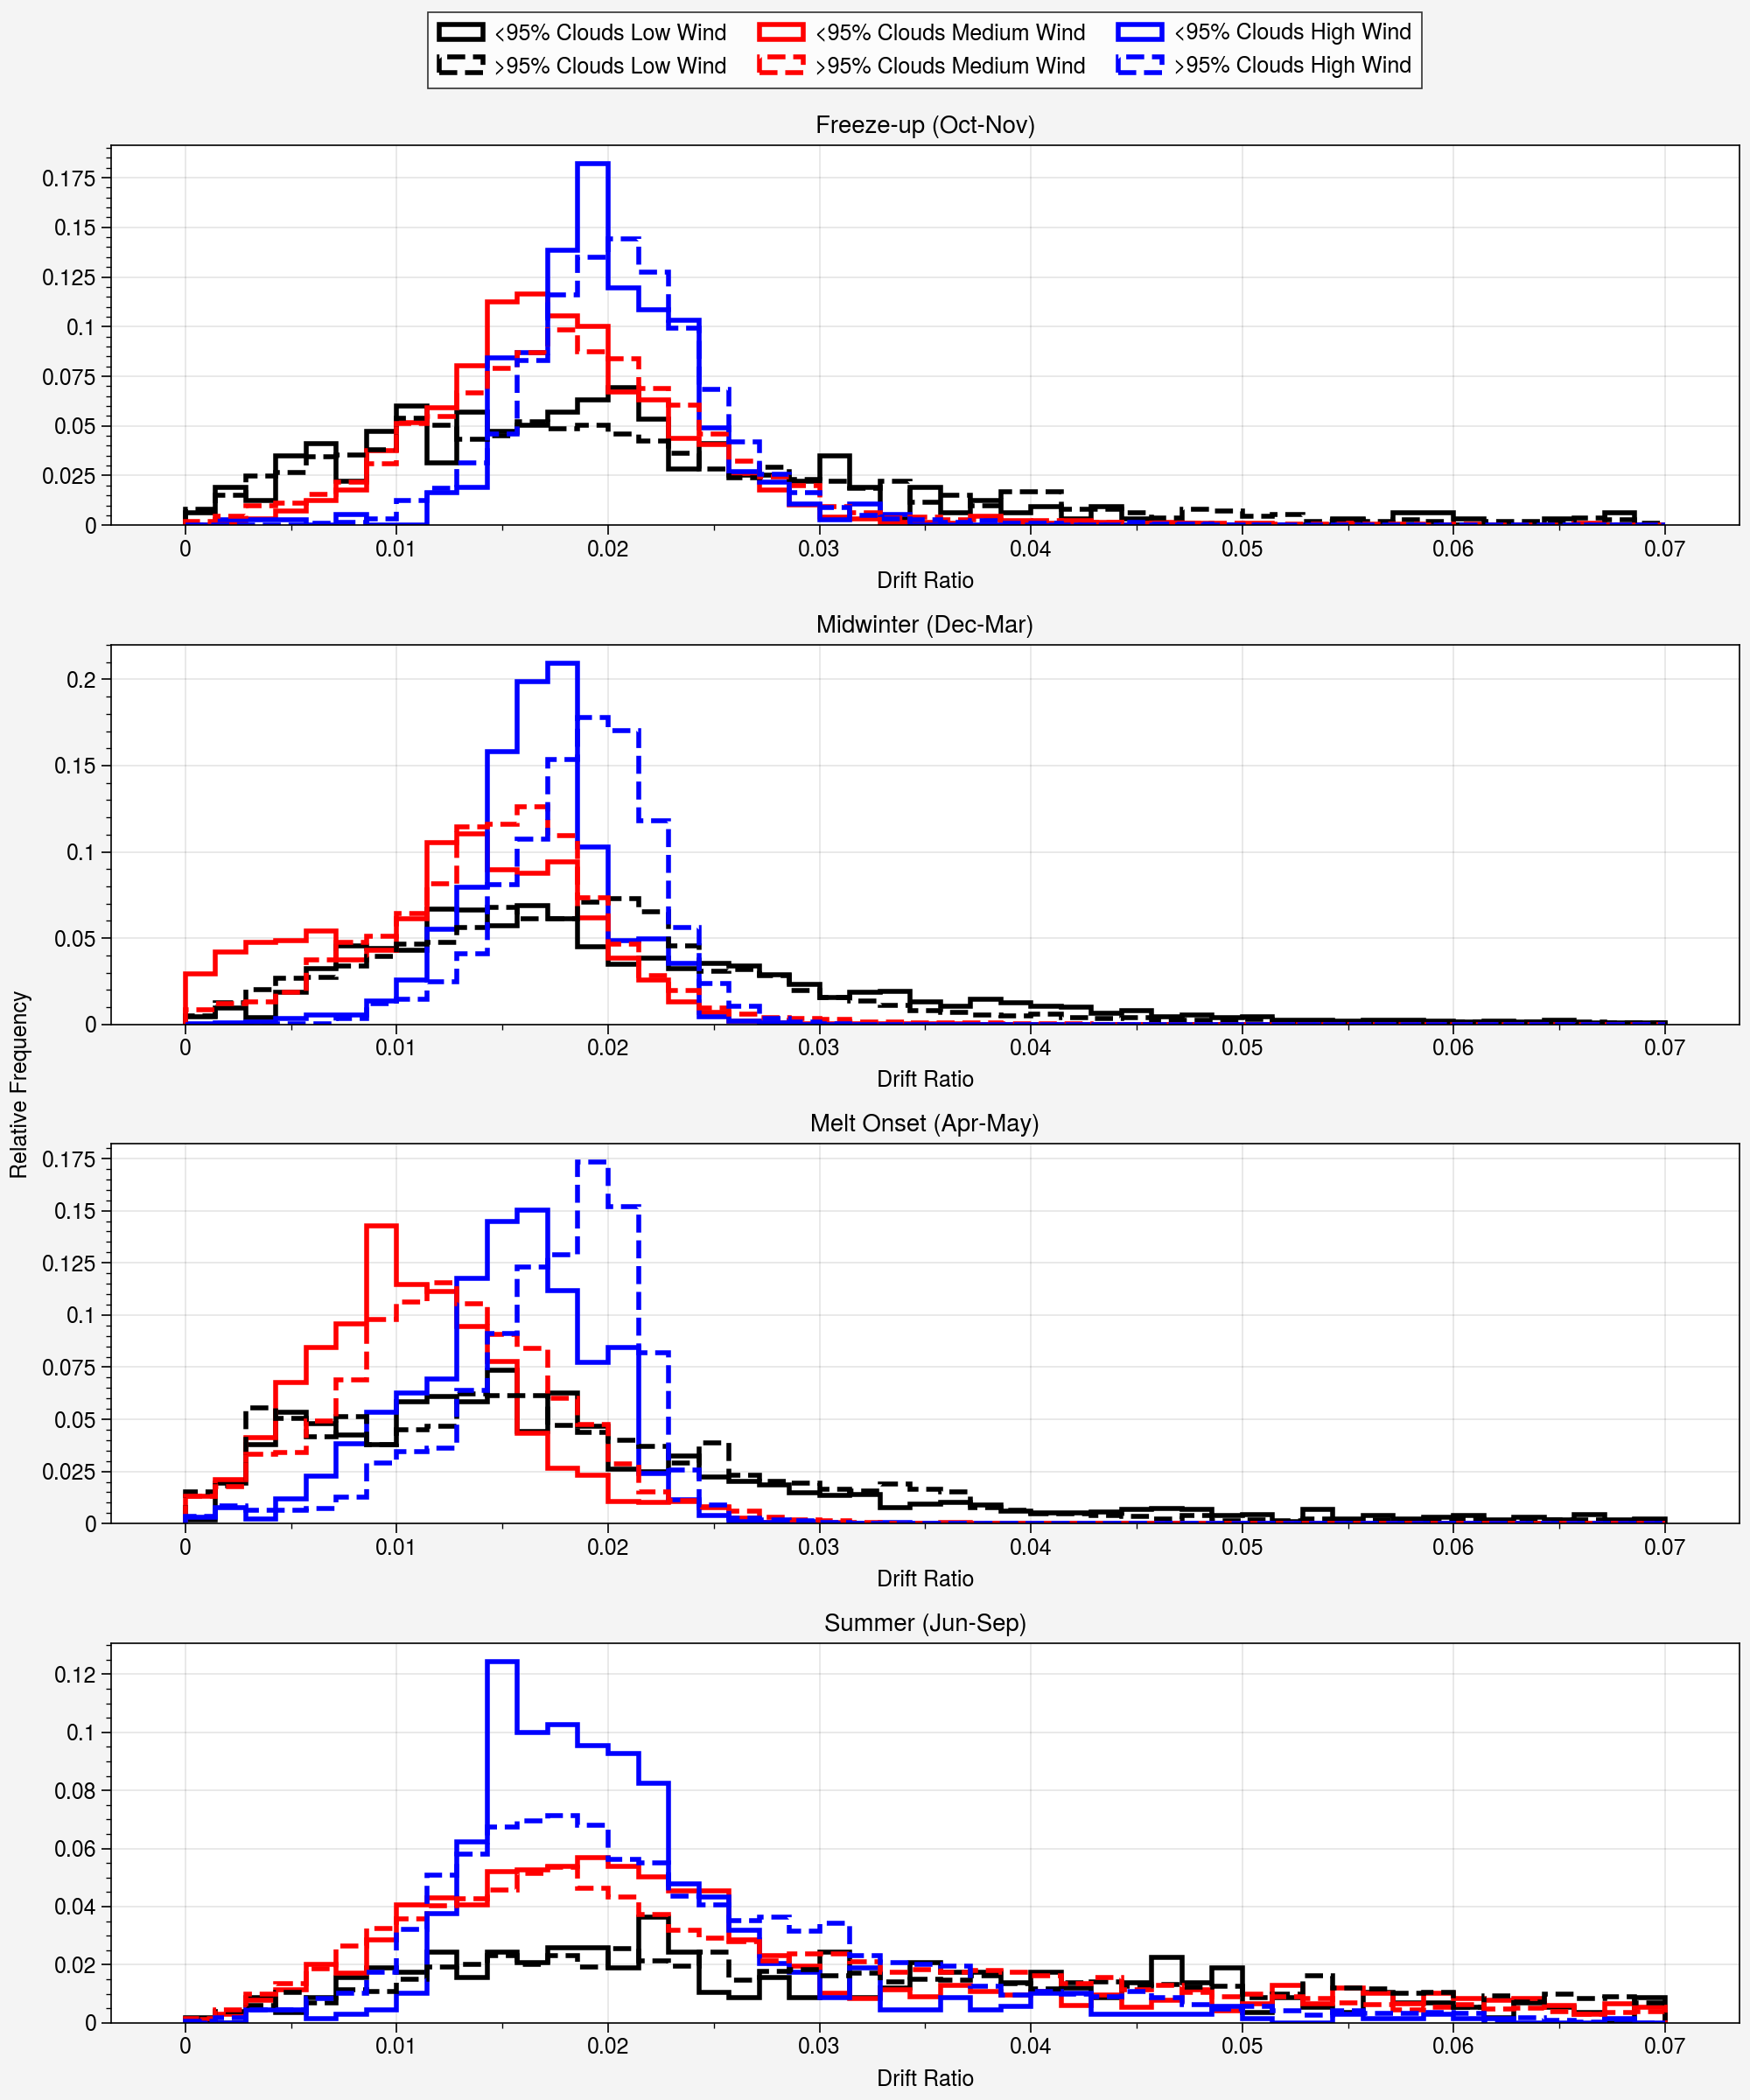

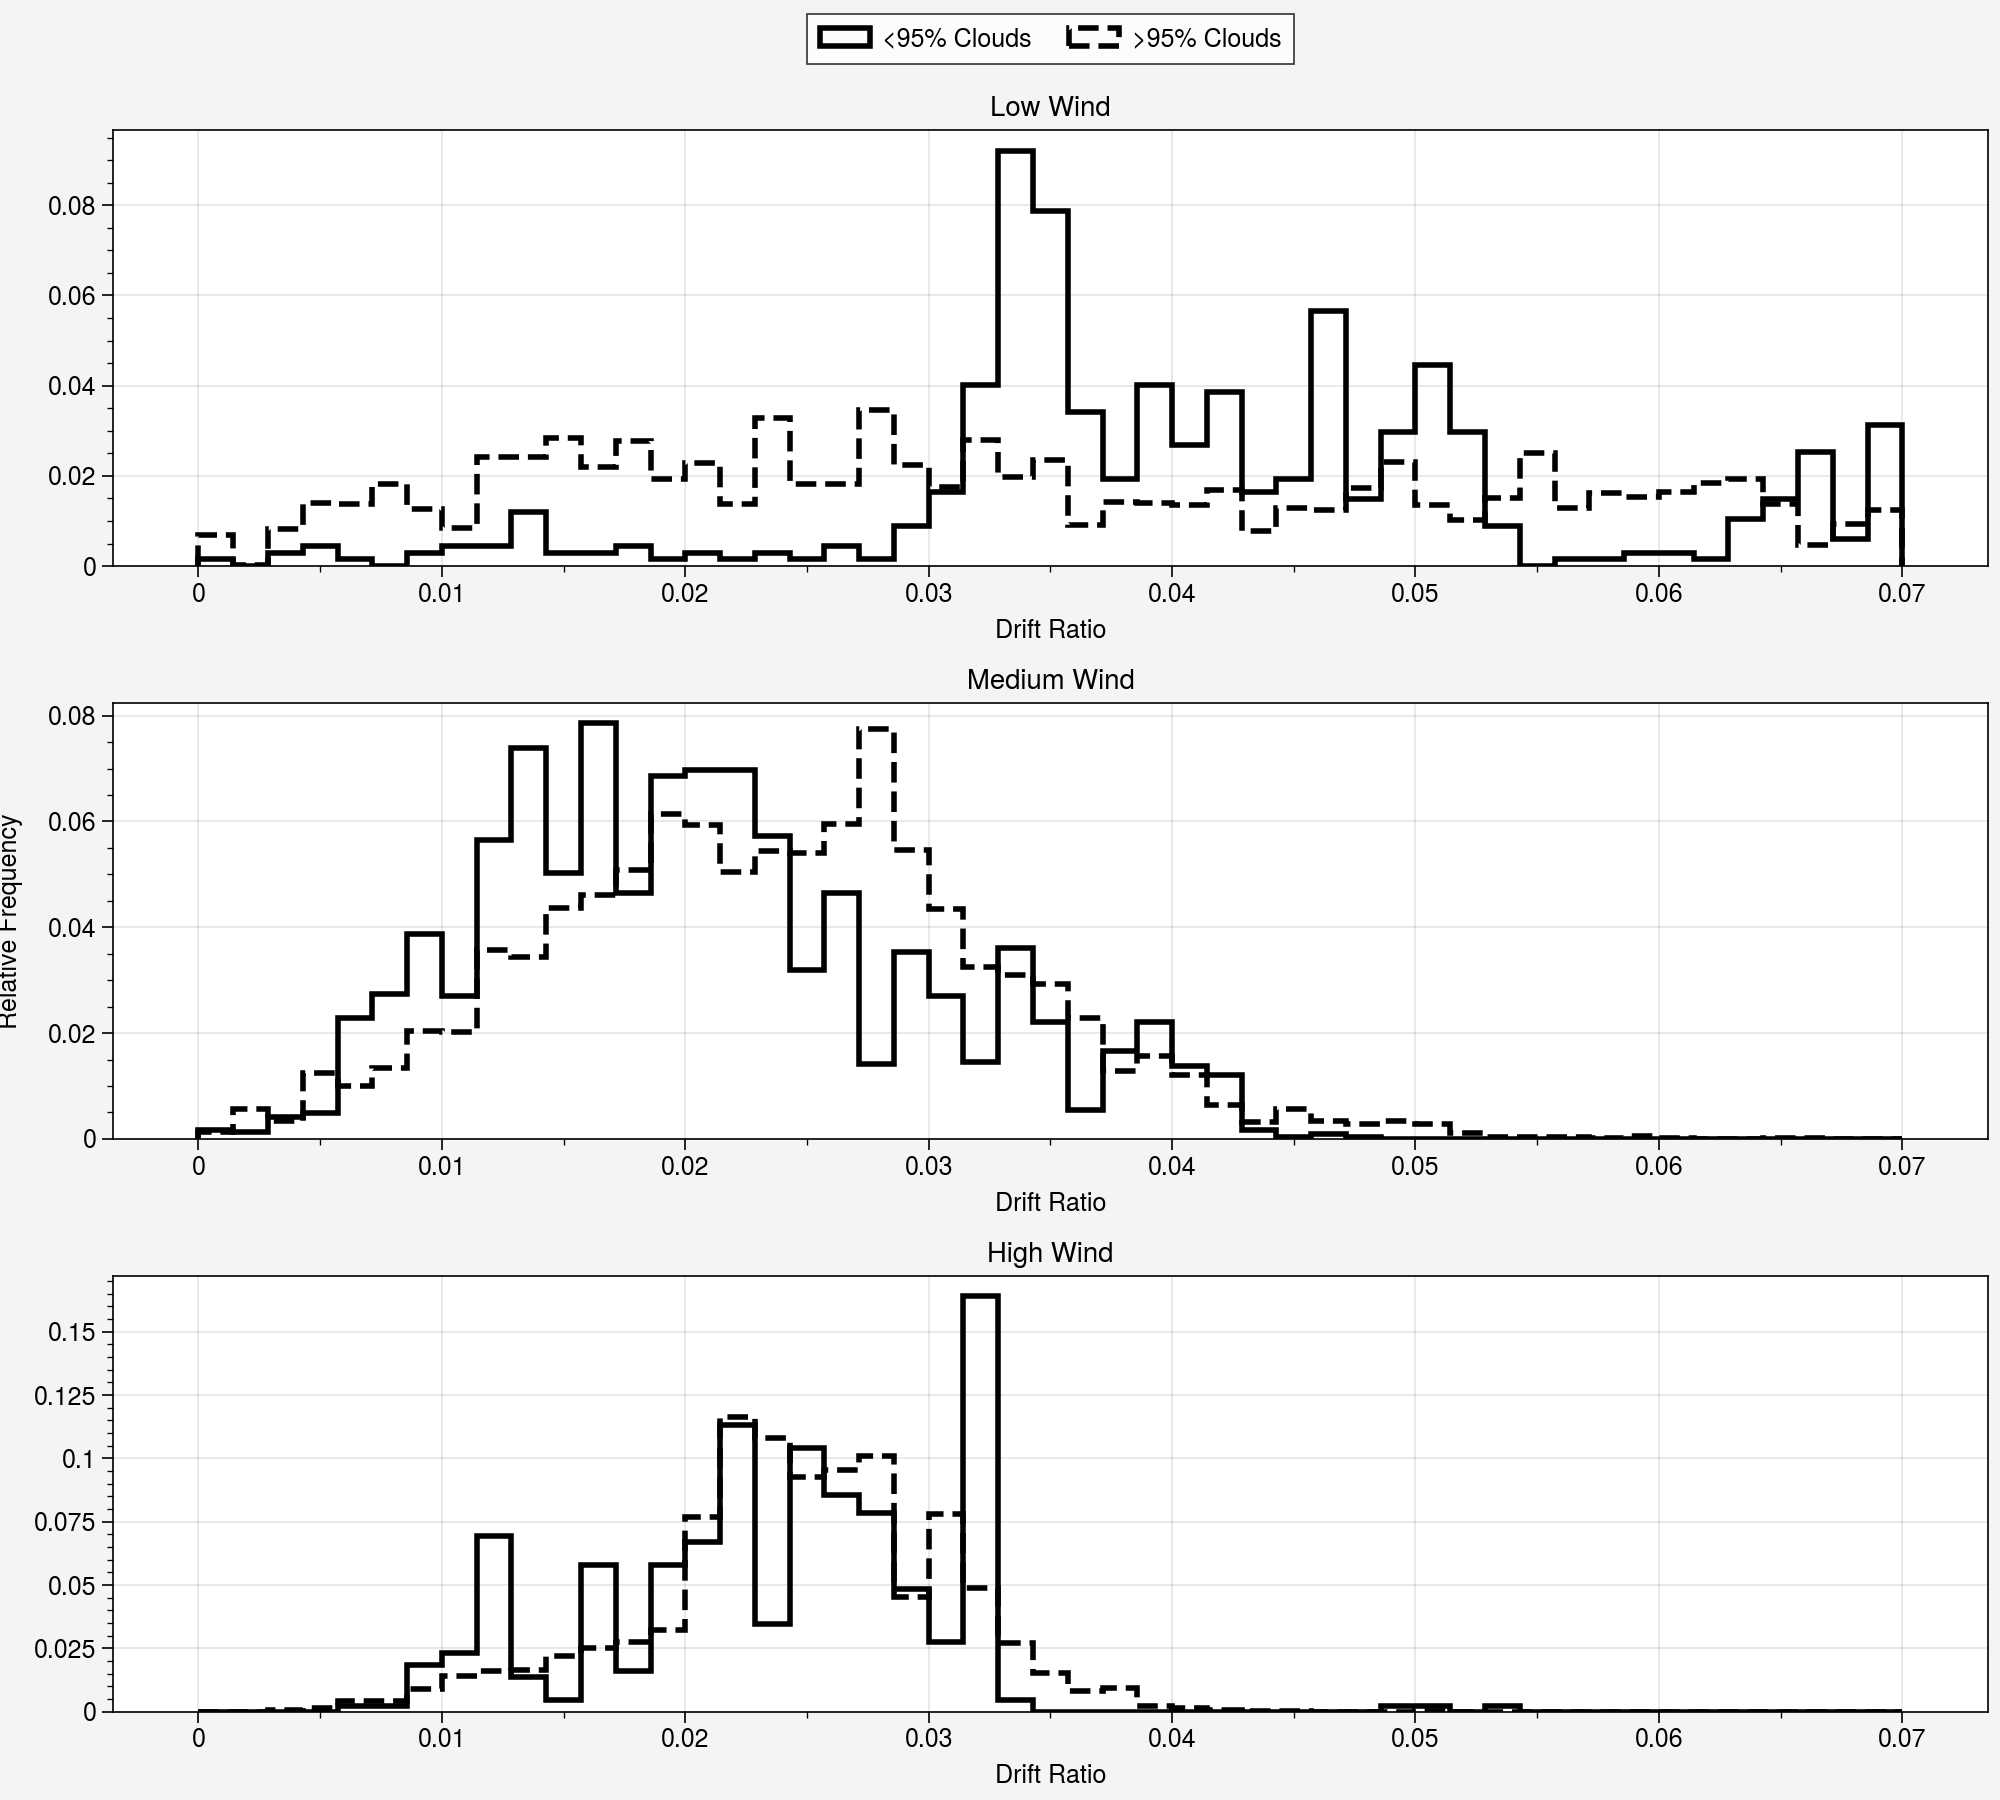

In [12]:
makeHist(df, "drift_ratio", 
         categories = {"season": seasons}, 
         overlays = {"cloud_cover": cloud_covers, "wind_level": wind_levels}, 
         num_bins=50, lims=[0,0.07])

makeHist(df2, "drift_ratio", 
         categories = {"wind_level": wind_levels}, 
         overlays = {"cloud_cover": cloud_covers}, 
         num_bins=50, lims=[0,0.07])

In [13]:
def statsTest(df, split_var, dep_var, categories):
    cat_names = list(categories.keys())
    data = df[[*cat_names, dep_var, split_var]]

    test_groups = list(df.groupby(split_var))
    if len(test_groups) != 2:
        raise(f"Number of split_var is {len(test_groups)}, expected 2")

    cat_groups = data.groupby(cat_names)
    print(f"T-test for difference between {split_var} {test_groups[0][0]} and {split_var} {test_groups[1][0]}")

    results = []
    for name, data in cat_groups:
        group_name = " ".join([categories[key][idx] for key, idx in zip(cat_names, name)])
        
        test_groups = list(data.groupby(split_var))
        test = stats.ttest_ind(a=test_groups[0][1][dep_var], b=test_groups[1][1][dep_var], equal_var=False, alternative="less")
        if "High" in group_name:
            results.append([group_name, test.statistic, test.pvalue, test.df])
    return pd.DataFrame(results, columns=["Category", "Statistic", "Pvalue", "DoF"])

In [14]:
statsTest(df, "cloud_cover", "drift_ratio", {"season": seasons, "wind_level": wind_levels})

'T-test for difference between cloud_cover 0 and cloud_cover 1'

,Category,Statistic,Pvalue,DoF
0,Freeze-up (Oct-Nov) High Wind,-2.955688,1.638097e-03,471.027136
1,Midwinter (Dec-Mar) High Wind,-46.458535,0.000000e+00,7743.960157
2,Melt Onset (Apr-May) High Wind,-31.530051,2.506006e-205,7506.760538
3,Summer (Jun-Sep) High Wind,-4.944944,4.411725e-07,1082.137710


# Next steps
1. Data grouping.
   * Pick date ranges to account for the changes in location, season and ice thickness. Freeze-up, winter, thaw, and summer. Dn2 separately.
   * Pick subsets of buoys so that you have the about the same number of observations for each day within a group. (Later: we can downsample to avoid having buoys that are clustered too closely)
2. For data display, consider using overlapping contour plots (so you can e.g. see the clear-sky and cloudy-sky data in one panel).
3. To highlight the differences between distributions, we can use "cross sections" - group the drift speed ratios by wind speed categories, and compare the distributions of clear and cloudy skies for each time section.
4. Make a map showing the trajectories for each date range. One map, color to show the date ranges. I can help with zooming in on the map and adding sea ice concentration. Do this in the "Buoy Processing.ipynb"

In [15]:
winter_spring = df[np.logical_or(df["season"] == 0, df["season"]==3)]

cloudy = (winter_spring[winter_spring.wind_speed_mps > 10]["cloud_cover"].sum())
total = (len(winter_spring[winter_spring.wind_speed_mps > 10]["cloud_cover"]))

print(cloudy/total)

0.9158009841443412

/home/alanxw/.micromamba/envs/sea-ice-utra/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


<a list of 1 Line2D objects>

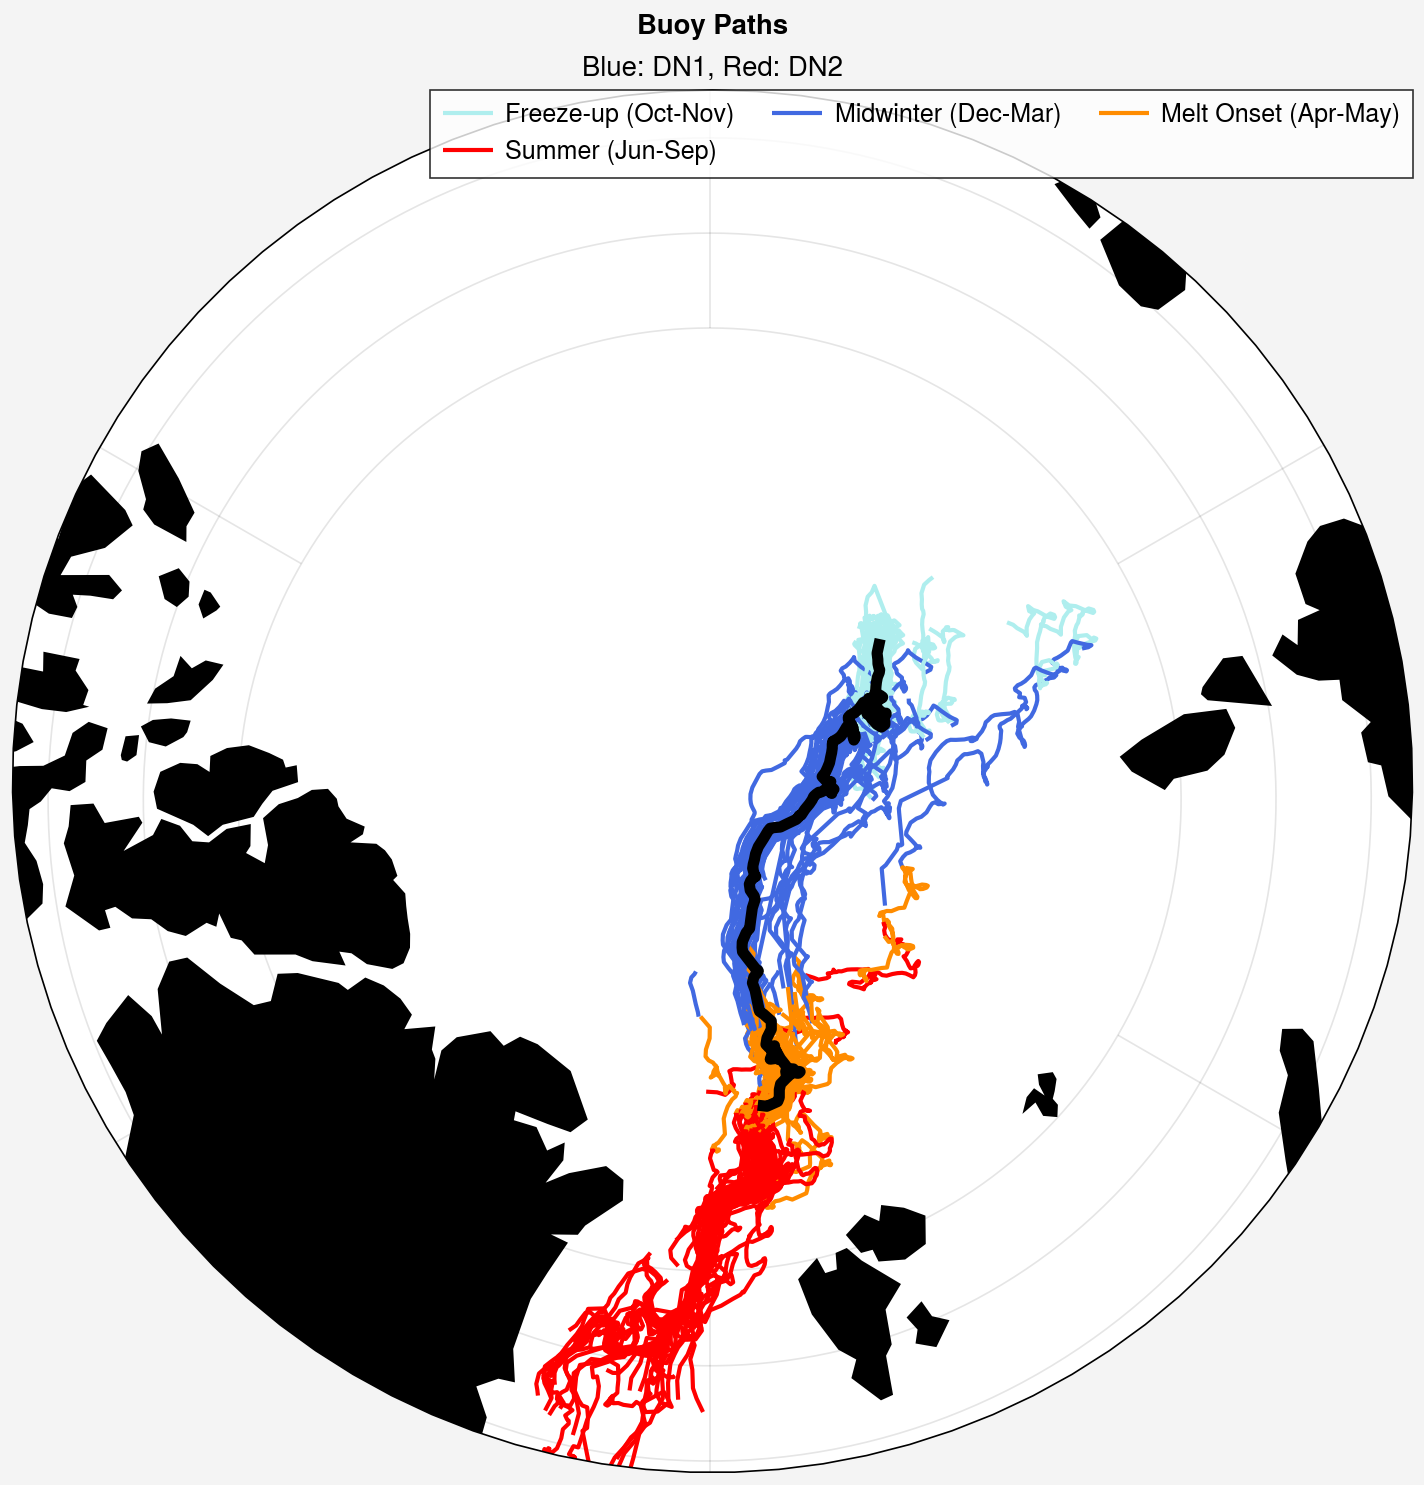

In [16]:
# Pole-centered map projections

fig, axs = pplt.subplots(ncols=1, refwidth=7, proj=('npstere'))
fig.format(suptitle='Buoy Paths')
axs.format(land=True)

dn1 = os.listdir("../data/daily_stations/mosaic_dn1")
dn2 = os.listdir("../data/daily_stations/mosaic_dn2")

axs[0].format(boundinglat=75, title='Blue: DN1, Red: DN2')

# Plot dn2 buoys in red, dn1 buoys in blue
#for station in [i[:-4] for i in dn2]:
#    axs[0].plot(station_data(station)['longitude'], station_data(station)['latitude'], color="red")
colors = ["paleturquoise",
          "royalblue",
          "darkorange",
          "red"]

for station in [i[:-4] for i in dn1]:
    data = station_data(station)
    data = data[data["datetime"] > pd.to_datetime("2019-10-01")]
    data = varClassifier(data,"datetime","season",season_ranges)
    season_groups = data.groupby(["season"])

    for group, data in season_groups:
        axs[0].plot(data['longitude'], data['latitude'], 
                    color=colors[group[0]], label=group[0])


handles, labels = axs[0].get_legend_handles_labels()

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(handles = [h[0] for h in unique], labels = [seasons[int(l[1])] for l in unique])
legend_without_duplicate_labels(axs[0])

co1 = station_data("CO1")
axs[0].plot(co1['longitude'], co1['latitude'], 
            color="black", label="Central Observatory", lw=4)
